# Создание пробной модели с коллаборативной фильтрацией с применением SVD

In [32]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')

### Использовать будем самые необходимые признаки.
1. Оценка разговора + флаг использования продукта из таблицы communications
2. Прохождение курсов пользователями из таблицы courses_passing

In [15]:
# Загружаем два датасета
communications = pd.read_csv(
    "../data/src/communications.csv",
    sep=';',
    dtype={'employee_id': 'category'},
    parse_dates=['communication_dt']
)
courses_passing = pd.read_csv(
    "../data/src/courses_passing.csv",
    sep=';',
    dtype={'employee_id': 'category'},
    parse_dates=['start_dt', 'end_dt']
)

### Отберём тех пользователей, которые курс окончили.

In [17]:
courses_passed = courses_passing.dropna(subset=['end_dt'])
cols_to_include = ['start_dt', 'course_id', 'employee_id', 'end_dt']
courses_passed = courses_passed.loc[:, cols_to_include]

In [18]:
# Создаём промежуток размером в месяц до начала курса
courses_passed['month_before'] = courses_passed['start_dt'] \
    - pd.DateOffset(days=30)
# Создаём промежуток размером в месяц после окончания курса
courses_passed['month_after'] = courses_passed['end_dt'] \
    + pd.DateOffset(days=30)

### Создадим промежутки "месяц до начала курса" и "месяц после окончания курса"

In [19]:
# Удаляем неинформативный атрибут
communications = communications.drop('communication_id', axis=1)

#### Перед нами стоит задача учесть влияние курсов на два ключевых показателя. <br> Сделаем это путём взвешенной оценки. Таким образом, мы учтём оба фактора

In [20]:
communications['weighted_mark'] = \
    communications['util_flg'] * 100 * 0.5 + \
    communications['communication_score'] * 0.5

In [21]:
communications.head()

,communication_dt,employee_id,communication_score,util_flg,weighted_mark
0,2023-02-07,269d837a-fada-308d-d4ae-ab28ca2d57e4,85,0,42.5
1,2023-07-29,e6384711-4917-13d2-9bc6-3fc5eeb5ba4f,100,0,50.0
2,2023-09-06,ab541d87-4c7b-c19a-b776-42849e02b89f,43,1,71.5
3,2023-06-19,0a0a0c8a-aa00-ade5-0f74-a3f0ca981ed7,100,1,100.0
4,2023-08-11,f93882cb-d8fc-7fb7-94c1-011d63be6fb6,46,0,23.0


In [22]:
# Удаляем преобразованные признаки
communications.drop(
    ['communication_score', 'util_flg'],
    axis=1,
    inplace=True
)

### Объединим две таблицы. 
Таким образом мы получаем для каждой оценки интервалы, которые сможем использовать<br> как промежуток времени до и промежуток после прохождения курса 

In [23]:
merged = communications.merge(courses_passed, how='inner', on='employee_id')

In [24]:
# Посмотрим на результат объединения
merged.head()

,communication_dt,employee_id,weighted_mark,start_dt,course_id,end_dt,month_before,month_after
0,2023-02-07,269d837a-fada-308d-d4ae-ab28ca2d57e4,42.5,2023-06-25,79,2023-07-05,2023-05-26,2023-08-04
1,2023-02-07,269d837a-fada-308d-d4ae-ab28ca2d57e4,42.5,2023-07-06,74,2023-07-15,2023-06-06,2023-08-14
2,2023-02-07,269d837a-fada-308d-d4ae-ab28ca2d57e4,42.5,2023-06-03,16,2023-06-09,2023-05-04,2023-07-09
3,2023-02-07,269d837a-fada-308d-d4ae-ab28ca2d57e4,42.5,2023-07-13,8,2023-07-20,2023-06-13,2023-08-19
4,2023-02-07,269d837a-fada-308d-d4ae-ab28ca2d57e4,42.5,2023-04-09,42,2023-04-15,2023-03-10,2023-05-15


In [25]:
# Удалим ненужные данные
del communications, courses_passed

Создадим условия, по которым разделим датасет на группы

In [26]:
# Коммуникации, которые были после курса и в пределах месяца
# следующего как контрольный после конца курса.
is_after = (merged['communication_dt'] > merged['end_dt'])\
    & (merged['communication_dt'] < merged['month_after'])
    
# Коммуникации, которые были до курса и в пределах месяца
# следующего как контрольный до начала курса.
is_before = (merged['communication_dt'] < merged['start_dt']) \
    & (merged['communication_dt'] > merged['month_before'])

Посчитаем среднюю оценку до курса и после для каждого отдельного пользователя. <br>Так получим непрерывное число отражающее потенциальное "желание" человека посмотреть этот курс.

In [27]:
mark_after_course = merged[is_after] \
    .groupby(['employee_id', 'course_id'])['weighted_mark'] \
    .agg('mean')
mark_before_course = merged[is_before] \
    .groupby(['employee_id', 'course_id'])['weighted_mark'] \
    .agg('mean')

In [28]:
# Считаем разницу и смотрим что получилось
diff_df = (mark_after_course - mark_before_course)
diff_df = diff_df.unstack()
diff_df

course_id,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
employee_id,,,,,,,,,,,,,,,,,,,,,
00411460-f7c9-2d21-24a6-7ea0f4cb5f85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.593618,-0.605890,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
006f52e9-102a-8d3b-e2fe-5614f42ba989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.588911,NaN,NaN,NaN,NaN
00a03ec6-533c-a7f5-c644-d198d815329c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-5.523111,NaN,NaN,NaN,NaN,NaN,7.075201,NaN,NaN
00ac8ed3-b432-7bdd-4ebb-ebcb2ba10a00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00e26af6-ac3b-1c1c-49d7-c3d79c60d000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.128442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff1418e8-cc99-3fe8-abcf-e3ce2003e5c5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.694379,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.221019,NaN,NaN
ff49cc40-a889-0e6a-60f4-0ff3026d2730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fface838-5abb-f94b-4593-a0ed53a0c70f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Создаём функцию scale_row
Эта функция принимает на вход строку данных row, которая представляет разницу в оценках до и после курса для конкретного пользователя.
Внутри функции мы находим минимальное и максимальное значение в строке min_val и max_val. Как результат эта формула масштабирует значения в диапазоне от 1 до 10. Непройденным курсам присвоим нулевое значение

In [29]:
def scale_row(row):
    min_val = row.min()
    max_val = row.max()
    return (row - min_val) / (max_val - min_val) * 9 + 1



# Применяем функцию к каждой строке
diff_df_scaled = diff_df.apply(scale_row, axis=1)
diff_df_scaled = diff_df_scaled.fillna(0)

In [30]:
# удалим лишнее из памяти
del merged, diff_df

При восстановлении исходной матрицы мы берем первые k столбцов из матрицы U, первые k строк и столбцов из матрицы Sigma, и первые k строки из матрицы Vt. Затем перемножаем эти матрицы, чтобы получить восстановленную матрицу.

Итак, параметр k позволяет нам контролировать количество информации, которую мы хотим сохранить при восстановлении. Большее значение k означает более точное восстановление исходной матрицы, но может также привести к переобучению и увеличению вычислительной сложности. Меньшее значение k означает более грубое приближение, но может быть более обобщающим.

In [31]:
best_k_mse = None
best_mse = float('inf')
best_k_mae = None
best_mae = float('inf')

for k in range(1, 150):  # Выборка k от 1 до 70
    U, sigma, Vt = np.linalg.svd(diff_df_scaled, full_matrices=False)
    # Восстановление оценок
    reconstructed_data = np.dot(U[:, :k] * sigma[:k], Vt[:k, :])

    # Вычисление MSE и MAE на всей выборке
    mse = mean_squared_error(diff_df_scaled, reconstructed_data)
    mae = mean_absolute_error(diff_df_scaled, reconstructed_data)

    # Сохраняем лучший результат для MSE
    if mse < best_mse:
        best_mse = mse
        best_k_mse = k

    # Сохраняем лучший результат для MAE
    if mae < best_mae:
        best_mae = mae
        best_k_mae = k

print("Best k for MSE:", best_k_mse)
print("Best MSE:", best_mse)
print("Best k for MAE:", best_k_mae)
print("Best MAE:", best_mae)

Best k for MSE: 92
Best MSE: 2.1651672672730888e-29
Best k for MAE: 92
Best MAE: 2.3808462854281238e-15


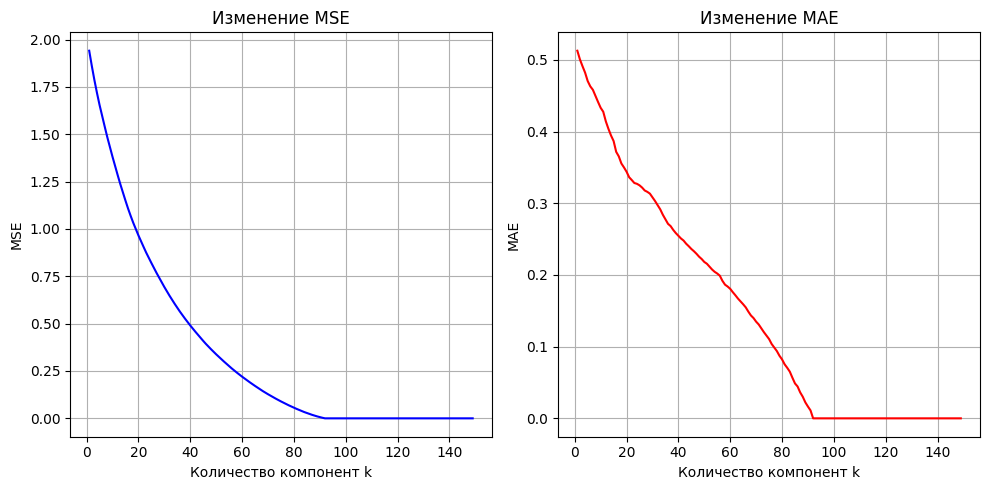

In [33]:
# Инициализация списков для сохранения результатов
ks = list(range(1, 150))
mses = []
maes = []

for k in ks:
    U, sigma, Vt = np.linalg.svd(diff_df_scaled, full_matrices=False)
    reconstructed_data = np.dot(U[:, :k] * sigma[:k], Vt[:k, :])
    mse = mean_squared_error(diff_df_scaled, reconstructed_data)
    mae = mean_absolute_error(diff_df_scaled, reconstructed_data)
    mses.append(mse)
    maes.append(mae)

# Построение графиков
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(ks, mses, label='MSE', color='blue')
plt.title('Изменение MSE')
plt.xlabel('Количество компонент k')
plt.ylabel('MSE')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(ks, maes, label='MAE', color='red')
plt.title('Изменение MAE')
plt.xlabel('Количество компонент k')
plt.ylabel('MAE')
plt.grid(True)

plt.tight_layout()
plt.show()

Обе метрики близки к нулю, поэтому модель довольно хорошо реконструировала исходные данные, а значит может быть использована в качестве рекомендаций. Берём лучший показатель и реализуем его в наших рекомендациях.

In [ ]:
# Выполнение SVD разложения
U, sigma, Vt = np.linalg.svd(diff_df_scaled, full_matrices=False)
k = 92
# Восстановление оценок
reconstructed_data = np.dot(U[:, :k] * sigma[:k], Vt[:k,:])
reconstructed_data

array([[ 9.42981389e-15,  3.19315059e-15,  1.17215937e-15, ...,
        -2.73172715e-16,  5.05468124e-15, -1.52832067e-15],
       [ 1.11737285e-14,  3.70370918e-15, -1.66379538e-15, ...,
         5.13088217e-15,  3.31869088e-15, -9.25356833e-15],
       [-1.15908006e-15, -3.47745453e-15,  1.79533257e-15, ...,
         7.36230940e+00,  1.05396191e-14,  7.96960914e-16],
       ...,
       [ 5.88058100e-15, -3.27096649e-15, -3.56366376e-15, ...,
         1.37967585e-14,  2.75929086e-15,  1.70140073e-16],
       [-3.69529965e-16,  5.00664895e-17, -1.31250132e-15, ...,
         4.69463394e+00, -2.53247207e-15,  1.43562795e-15],
       [ 8.56602511e-15, -6.21697804e-15, -5.11614121e-15, ...,
         4.18518496e-15,  1.12407460e-15, -2.23471414e-15]])

На основе восстановленной матрицы reconstructed_data сделаем рекомендации курсов для каждого сотрудника. Каждому сотруднику сделаем по 20 рекомендаций курсов.

In [ ]:
num_recommendations = 20

# Преобразуем reconstructed_data в DataFrame
reconstructed_df = pd.DataFrame(
    reconstructed_data, index=diff_df_scaled.index, columns=diff_df_scaled.columns)

# Создаем пустой DataFrame для хранения рекомендаций
all_recommendations = pd.DataFrame(
    columns=['employee_id', 'course_id', 'course_pred'])

In [ ]:
# Проходим по каждому сотруднику
for employee_id, row in reconstructed_df.iterrows():
    # Сортируем предсказанные оценки по убыванию и берем первые num_recommendations
    top_recommendations = row.sort_values(
        ascending=False).head(num_recommendations)

    # Создаем DataFrame для текущего сотрудника
    recommendations_df = pd.DataFrame({
        'employee_id': [employee_id] * num_recommendations,
        'course_id': top_recommendations.index,
        'course_pred': top_recommendations.values
    })

    # Добавляем к общему DataFrame
    all_recommendations = pd.concat(
        [all_recommendations, recommendations_df], ignore_index=True)

# Теперь у нас есть DataFrame со 20 рекомендациями для каждого сотрудника
print("Top 20 Recommendations for Each Employee:")
print(all_recommendations)

Top 20 Recommendations for Each Employee:
                                employee_id course_id   course_pred
0      00411460-f7c9-2d21-24a6-7ea0f4cb5f85        50  1.000000e+01
1      00411460-f7c9-2d21-24a6-7ea0f4cb5f85        20  4.759984e+00
2      00411460-f7c9-2d21-24a6-7ea0f4cb5f85         7  4.165673e+00
3      00411460-f7c9-2d21-24a6-7ea0f4cb5f85         8  4.151556e+00
4      00411460-f7c9-2d21-24a6-7ea0f4cb5f85        29  1.000000e+00
...                                     ...       ...           ...
33535  ffeed84c-7cb1-ae7b-f4ec-4bd78275bb98        57  5.242252e-15
33536  ffeed84c-7cb1-ae7b-f4ec-4bd78275bb98        41  4.975133e-15
33537  ffeed84c-7cb1-ae7b-f4ec-4bd78275bb98        62  4.904514e-15
33538  ffeed84c-7cb1-ae7b-f4ec-4bd78275bb98        18  4.669427e-15
33539  ffeed84c-7cb1-ae7b-f4ec-4bd78275bb98        29  4.564588e-15

[33540 rows x 3 columns]


### Интерпретация
Для пользователя под id "00411460-f7c9-2d21-24a6-7ea0f4cb5f85" наиболее рекомендуемый курс под id 50, на втором месте под id 20 и так далее

## Итоги
1. Мы начали с загрузки двух датасетов: communications.csv и courses_passing.csv.
2. Из courses_passing.csv мы выбрали только те записи, где курс был окончен (courses_passed), и создали столбцы month_before и month_after, чтобы определить период до и после прохождения курса.
3. Мы объединили данные из communications.csv и courses_passed, чтобы иметь информацию об оценках и коммуникациях перед и после прохождения курсов (merged).
4. Создали взвешенную оценку weighted_mark на основе оценок разговоров и флага использования продукта.
5. Разделили датасет на "период до курса" и "период после курса" и посчитали среднюю оценку для каждого курса для каждого сотрудника (mark_before_course и mark_after_course).
6. Вычислили разницу между оценками до и после курса, создали матрицу оценок diff_df, затем масштабировали ее в диапазоне от 1 до 10.
7. Произвели SVD разложение (U, Sigma, Vt) и восстановили матрицу оценок reconstructed_data.
8. Подобрали оптимальное значение параметра k для SVD с помощью минимизации MSE и MAE.
9. На основе восстановленной матрицы reconstructed_data сделали рекомендации курсов для каждого сотрудника. Каждому сотруднику предложили по 20 рекомендаций курсов.
10. Вывели итоговую таблицу с рекомендациями, где для каждого сотрудника указаны employee_id, course_id и предсказанный рейтинг course_pred.